## NuMI Analysis: Nue Smearing

#### Get the smearing matix for nue

First, setup.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward
from collections import defaultdict

main_path = ls.main_path
sys.path.append(main_path)

/home/alex/NuMI/PELEE/


In [15]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

In [16]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

Now get some data.

In [17]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

['shrmoliereavg', 'shr_energy', 'shr_phi', 'sub', 'ccnc', 'tksh_angle', 'shr_theta', 'shr_tkfit_dedx_U', 'nu_pdg', 'n_showers', 'nproton', 'slnunhits', 'n_tracks', 'n_tracks_contained', 'tksh_distance', 'reco_nu_vtx_sce_x', 'category', 'npion', 'trk_energy', 'shr_py', 'selected', 'shr_energy_cali', 'shr_tkfit_nhits_V', 'shr_pz', 'shr_tkfit_dedx_V', 'trk_score_v', 'CosmicIPAll3D', 'shrsubclusters2', 'shr_tkfit_nhits_U', 'trk_energy_tot', 'hits_ratio', 'reco_nu_vtx_sce_z', 'shr_tkfit_dedx_Y', 'shr_distance', 'n_showers_contained', 'shrsubclusters0', 'contained_fraction', 'evt', 'shr_energy_tot_cali', 'topological_score', 'slnhits', 'flash_time', 'reco_nu_vtx_sce_y', 'shr_score', 'trkshrhitdist2', 'shr_tkfit_nhits_Y', 'shr_px', 'shr_tkfit_npoints', 'shrsubclusters1', 'run', 'nslice']


The following cell allows us to reload original data event weights. No weights have been added to data or ext so these are not included.

In [18]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    
#BDT

In [19]:
# Let's calculate the weights that we need to apply to the individual MC events 
# to become our best model of the NuMI data. 
# This cell calculates the GENIE Tune * PPFX correction to the MC weights and 
# cleans up extremely high (or low) weight scores (may be due to computational errors).
# The clean up is not the best practice (one should dig and understand why the weight are big/negative): 
# it's a cheat until we figure out the next best thing. Life is not perfect and your analysis won't be either. Please enojy LArbys

constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

#BDT

Get Log Likelihood Ratio Particle ID for track candidates. Will need proton for nue, muon for numu.

In [20]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [21]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [9]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [22]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

#BDT

time to run:  27.028661251068115


In [23]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [24]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']


In [25]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [26]:
# add back the cosmic category, for background only
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    
#BDT    

In [27]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304    

In [28]:
#Define signal catagories

nue_nue["is_signal"] = nue_nue["category"] == 11

In [29]:
# Some quick clean up since some strange events get in there
nue  = nue_nue.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    


## Selection Section

In [30]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

## BDT

In [31]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [32]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [33]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_nue]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(127551, 119)


In [34]:
datasets_bdt = nue_nue

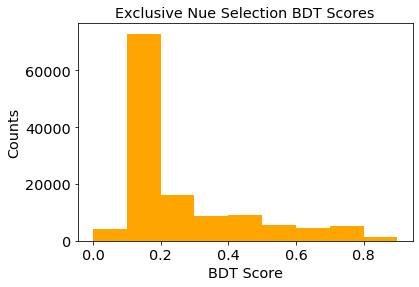

In [35]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [36]:
###Need to use the same BDT split value Katerina did
#It was BDT score > 0.575

SEL_QUERY = BDT_LOOSE_CUTS
SEL_QUERY += ' and BDT_score > 0.575'

## Smearing with Weights test

In [37]:
truthsel_nue  = " and (nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
truthsel_nue  += " and category == 11"

truthsel_nue_only  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
truthsel_nue_only  += " and category == 11"

In [38]:
TOTAL_QUERY = SEL_QUERY
TOTAL_QUERY += truthsel_nue

n_events here =  127551

1.0
1
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[1.2228513  0.5187539  0.42641643 ... 1.1436439  0.8197148  0.56377584]
1
2
3
current_total  370.8856763625695
[]

SUMS
[]
[]

Wanted List:
[]

current_wanted_list  []
current_total_hist  [ 30.08481083 151.62865505 111.03931566  43.90048764  16.85484445
   8.27149273   4.82925683   2.50250452   1.27365342   0.50065524]

current n_tot  [ 30.08481083 151.62865505 111.03931566  43.90048764  16.85484445
   8.27149273   4.82925683   2.50250452   1.27365342   0.50065524]
total array  [2.3619804  1.1512005  0.7492392  ... 0.81428844 1.0175847  2.0369437 ]
total weight arr

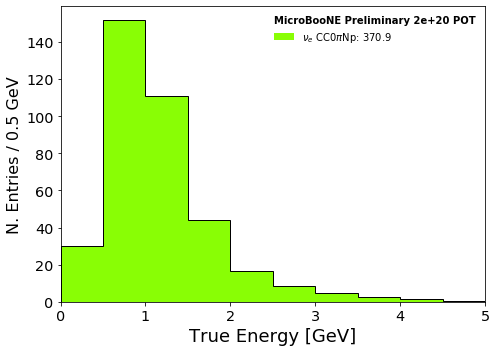

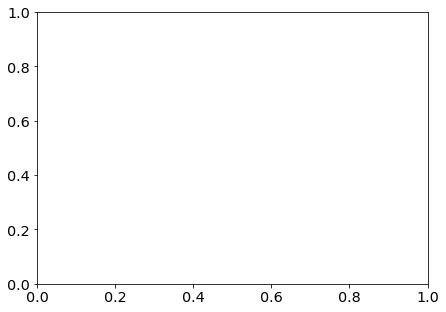

In [39]:
##THE TRUTH

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss1 = []
weightss1 = []
labss1 = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    nueratio  = pot/2.37838e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]" 
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var1, weight1, label1 = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        #query= TOTAL_QUERY,
        query=truthsel_nue_only,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss1.append(var1)
    weightss1.append(weight1)
    labss1.append(label1)

No handles with labels found to put in legend.


(array([ 30.08481083, 151.62865505, 111.03931566,  43.90048764,
        16.85484445,   8.27149273,   4.82925683,   2.50250452,
         1.27365342,   0.50065524]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ],
      dtype=float32), <a list of 10 Patch objects>)
(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]), <a list of 10 Patch objects>)


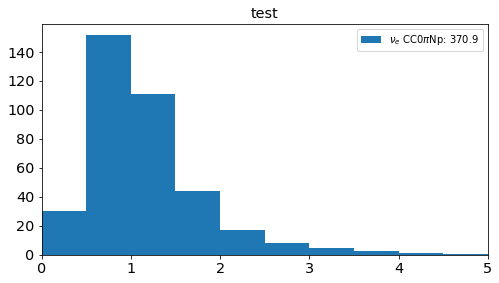

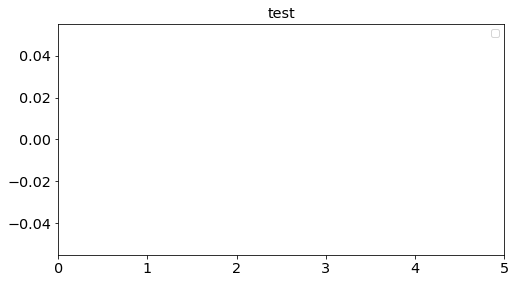

In [40]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss1[i].values(),
                weights=list(weightss1[i].values()),
                stacked=True,
                label=labss1[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()
    
    print(nue_stacked)
    #temp_truth_sig = nue_stacked[0]
    #print(temp_truth_sig)

[ 30.08481083 151.62865505 111.03931566  43.90048764  16.85484445
   8.27149273   4.82925683   2.50250452   1.27365342   0.50065524]
30.08481082750219


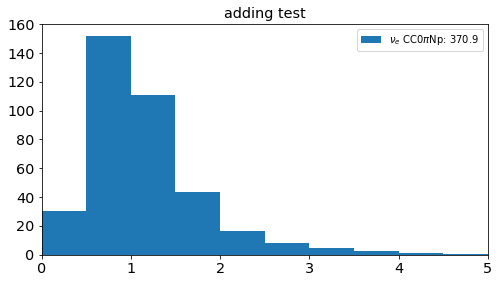

In [41]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss1)
weightss_tot = combine_dicts(weightss1)


category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss1[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 160])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 180])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

print(nue_stacked[0])

temp_truth_sig = nue_stacked[0]
print(temp_truth_sig[0])

n_events here =  127551

1.0
1
{'nue_nue': 0.008409085175623745}
nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575 and (nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[1.2228513 1.1877642 1.5490692 ... 1.1190536 1.0368681 1.1124349]
1
2
3
current_total  56.99571519411808
[]

SUMS
[]
[]

Wanted List:
[]

current_wanted_list  []
current_total_hist  [1.04492241e+01 3.10782484

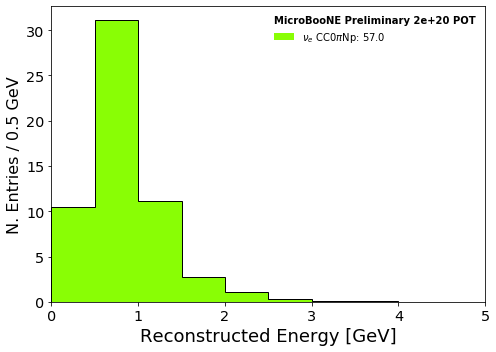

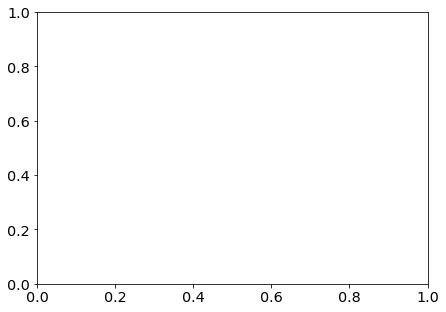

In [42]:
# NOW WITH RECO SELECTION

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss2 = []
weightss2 = []
labss2 = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    nueratio  = pot/2.37838e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var2, weight2, label2 = my_plotter.plot_variable(
        VARIABLE,
        query= TOTAL_QUERY,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss2.append(var2)
    weightss2.append(weight2)
    labss2.append(label2)

No handles with labels found to put in legend.


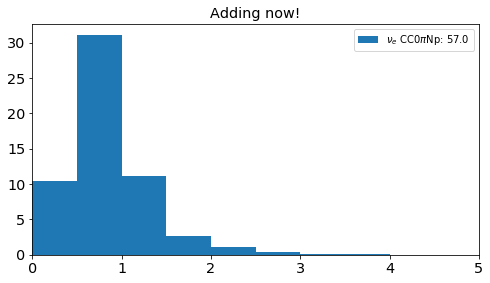

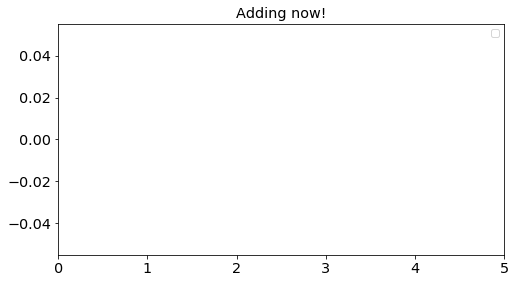

In [43]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss2[i].values(),
                weights=list(weightss2[i].values()),
                stacked=True,
                label=labss2[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [54]:
# plot the smearing matrix 
def plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(var1, var2,
                   bins, weights=weight1, cmin=0.000000001, cmap='OrRd')
    
    zero_copy_smear = np.copy(smear[0].T)
    
    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if np.isnan(zero_copy_smear[i,j]):
                zero_copy_smear[i,j]= 0

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
        
        gen = plt.hist(var3, bins, weights=weight3, color='deepskyblue')
        #gen = plt.hist(var1, bins, weights=weight1,color='deepskyblue')
        #gen = plt.hist(var1, bins, color='deepskyblue')
        print("")
        print("GENERATED")
        print(gen[0])
        print("")
        plt.close()
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            #reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            #tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1):
                norm_array[i][j] =  norm_array[i][j] / gen[0][j]
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
        
        zero_copy_smear_norm = np.copy(norm_array)

        for i in range(len(bins)-1): # reco bins i (y axis) rows
            for j in range(len(bins)-1): # true bins j (x axis) cols
                if np.isnan(zero_copy_smear_norm[i,j]):
                    zero_copy_smear_norm[i,j]= 0

        print(zero_copy_smear_norm)
    
        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)
        
        np.savetxt("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept_weighted.csv", 
           zero_copy_smear_norm,
           delimiter =", ", 
           fmt ='% s')
        
        with open('nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal.csv') as file:
            content = file.readlines()
        prior_true = content[0:]

        for i in range(10):
            prior_true[i]=prior_true[i].rstrip().rstrip(',')
            prior_true[i] = float(prior_true[i])

        print("Prior Truth: ")
        print(prior_true)
        print("")

        with open('nue_full_500_catsel_nopions_recoE_usingSelection_data_signal_MCONLY.csv') as file:
            content = file.readlines()
        mcsig = content[0:]

        for i in range(10):
            mcsig[i]=mcsig[i].rstrip().rstrip(',')
            mcsig[i] = float(mcsig[i])
            
        print("")

        print("SMEAR x PRIOR_TRUE")
        made_data_sig = np.dot(zero_copy_smear_norm, prior_true)
        print(made_data_sig)
        print("")
        print("MC DATA SIGNAL")
        print(mcsig)
        print("")
        print("DIFFERENCES")
        
        for i in range(10):
            print(made_data_sig[i] - mcsig[i])

    plt.xlabel('True ν Energy [GeV]', fontsize=15)
    plt.ylabel('Reco ν Energy [GeV]', fontsize=15)
    plt.text(0.1, 4.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()

In [51]:
bins = np.arange(0, 5.5, 0.5)

var1 = varss1[i].values()
weight1 = list(weightss1[i].values())

var2 = varss2[i].values()
weight2 = list(weightss2[i].values())

# relationship between true & reco values
plot_smearing(var1, var2, weight1, weight2, bins)

IndexError: list index out of range

In [52]:
def _selection(variable, sample, query="selected==1", extra_cut=None, track_cuts=None, select_longest=True):
        '''
        variable,  must be specified
        select_longest, True by default, keeps from multiple tracks of same event making it through
        query must be a string defining event-level cuts
        track_cuts is a list of cuts of which each entry looks like
            (variable_tobe_cut_on, '>'or'<'or'=='etc, cut value )
            or
            (variable, [operator1, operator2], [cutval1, cutval2]) to do an 'or' cut
        track_
        returns an Series of values that pass all track_cuts
        '''
        sel_query = query
        if extra_cut is not None:
            sel_query += "& %s" % extra_cut
        '''
        if ( (track_cuts == None) or (select_longest == False) ):
            return sample.query(sel_query).eval(variable).ravel()
        '''


        '''
        df = sample.query(sel_query)
        #print (df.isna().sum())
        dfna = df.isna()
        for (colname,colvals) in dfna.iteritems():
            if (colvals.sum() != 0):
                print ('name : ',colname)
                print ('nan entries : ',colvals.sum())
        '''  
        df = sample.query(sel_query)
        
        #if (track_cuts != None):
        #    df = sample.query(sel_query).dropna().copy() #don't want to eliminate anything from memory

        #df = sample.query(sel_query).dropna().copy() #don't want to eliminate anything from memory

        track_cuts_mask = None #df['trk_score_v'].apply(lambda x: x == x) #all-True mask, assuming trk_score_v is available
        if track_cuts is not None:
            vars, track_cuts_mask = _apply_track_cuts(df,variable,track_cuts,track_cuts_mask)
        else:
            vars = df[variable]
        #vars is now a Series object that passes all the cuts
        #select longest of the cut passing tracks
        #assuming all track-level variables end in _v
        if variable[-2:] == "_v" and select_longest:
            vars, longest_mask = _select_longest(df, vars, track_cuts_mask)
        elif "_v_" in variable:
            print("Variable is being interpretted as event-level, not track_level, despite having _v in name")
            print("the longest track is NOT being selected")
        return vars.ravel()
    
#-------------------------------------------------------------------
def _apply_track_cuts(df,variable,track_cuts,mask):
    '''
    df is dataframe of the sample of interest
    variable is what values will be in the output
    track_cuts are list of tuples defining track_cuts
    input mask to be built upon

    returns
        Series of values of variable that pass all track_cuts
        boolean mask that represents union of input mask and new cut mask
    '''
    #need to do this fancy business with the apply function to make masks
    #this is because unflattened DataFrames are used
    for (var,op,val) in track_cuts:
        if type(op) == list:
            #this means treat two conditions in an 'or' fashion
            or_mask1 = df[var].apply(lambda x: eval("x{}{}".format(op[0],val[0])))#or condition 1
            or_mask2 = df[var].apply(lambda x: eval("x{}{}".format(op[1],val[1])))#or condition 2
            mask *= (or_mask1 + or_mask2) #just add the booleans for "or"
        else:
            mask *= df[var].apply(lambda x: eval("x{}{}".format(op,val))) #layer on each cut mask
    vars = (df[variable]*mask).apply(lambda x: x[x != False]) #apply mask
    vars = vars[vars.apply(lambda x: len(x) > 0)] #clean up empty slices
    #fix list comprehension issue for non '_v' variables
    if variable[-2:] != "_v":
        vars = vars.apply(lambda x: x[0])
    elif "_v" not in variable:
        print("_v not found in variable, assuming event-level")
        print("not fixing list comprehension bug for this variable")

    return vars, mask
    
#-----------------------------------------------------------------------

def _select_longest(df, variable, mask):
    '''
    df: dataframe for sample
    variable: Series of values that pass cuts defined by mask
    mask: mask used to find variable

    returns
        list of values of variable corresponding to longest track in each slices
        boolean mask for longest tracks in df
    '''

    #print("selecting longest...")
    #print("mask", mask)
    trk_lens = (df['trk_len_v']*mask).apply(lambda x: x[x != False])#apply mask to track lengths
    trk_lens = trk_lens[trk_lens.apply(lambda x: len(x) > 0)]#clean up slices
    variable = variable.apply(lambda x: x[~np.isnan(x)])#clean up nan vals
    variable = variable[variable.apply(lambda x: len(x) > 0)] #clean up empty slices
    nan_mask = variable.apply(lambda x: np.nan in x or "nan" in x)
    longest_mask = trk_lens.apply(lambda x: x == x[list(x).index(max(x))])#identify longest
    variable = (variable*longest_mask).apply(lambda x: x[x!=False])#apply mask
    if len(variable.iloc[0]) == 1:
        variable = variable.apply(lambda x: x[0] if len(x)>0 else -999)#expect values, not lists, for each event
    else:
        if len(variable.iloc[0]) == 0:
            raise ValueError(
                "There is no longest track per slice")
        elif len(variable.iloc[0]) > 1:
            #this happens with the reco_nu_e_range_v with unreconstructed values
            print("there are more than one longest slice")
            print(variable.iloc[0])
            try:
                variable = variable.apply(lambda x: x[0])
            except:
                raise ValueError(
                    "There is more than one longest track per slice in \n var {} lens {}".format(variable,trk_lens))

    return variable, longest_mask
    
#-----------------------------------------------------------------------
def _get_genie_weight(sample, variable, query="selected==1", extra_cut=None, track_cuts=None,\
                          select_longest=True, weightvar="weightSplineTimesTuneTimesPPFX",weightsignal=None):

        plotted_variable = _selection(
            variable, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        genie_weights = _selection(
            weightvar, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        if (weightsignal != None):
            genie_weights *= _selection(
            weightsignal, sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
        if plotted_variable.size > 0:
            if isinstance(plotted_variable[0], np.ndarray):
                if "trk" in variable or select_longest:
                    score = self._selection(
                        "trk_score_v", sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
                else:
                    score = self._selection(
                        "shr_score_v", sample, query=query, extra_cut=extra_cut, track_cuts=track_cuts, select_longest=select_longest)
                genie_weights = np.array([
                    np.array([c] * len(v[s > 0.5])) for c, v, s in zip(genie_weights, plotted_variable, score)
                ])
                genie_weights = np.hstack(genie_weights)
        return genie_weights
    
    

All is well.


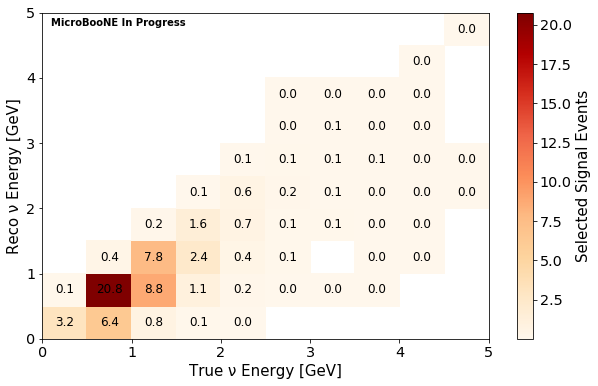


GENERATED
[ 30.08480453 151.62806702 111.03919983  43.90078735  16.85549927
   8.27182007   4.82931519   2.50286865   1.27365112   0.50073242]

[[0.10586965 0.04199827 0.00687956 0.00286733 0.00037142 0.
  0.         0.         0.         0.        ]
 [0.00425126 0.13706252 0.07903295 0.02527324 0.01218901 0.00452977
  0.00433369 0.00747233 0.         0.        ]
 [0.         0.00261588 0.06990077 0.05425728 0.02598201 0.01737809
  0.         0.00418053 0.00802186 0.        ]
 [0.         0.         0.00154923 0.03567791 0.04335191 0.01441124
  0.02096925 0.00844472 0.00799013 0.        ]
 [0.         0.         0.         0.00187452 0.03717838 0.02610001
  0.01419046 0.017531   0.01309051 0.01740218]
 [0.         0.         0.         0.         0.00307832 0.01649114
  0.01236893 0.02022008 0.01350616 0.02032569]
 [0.         0.         0.         0.         0.         0.00220268
  0.01565693 0.01231385 0.00965653 0.        ]
 [0.         0.         0.         0.         0.         0

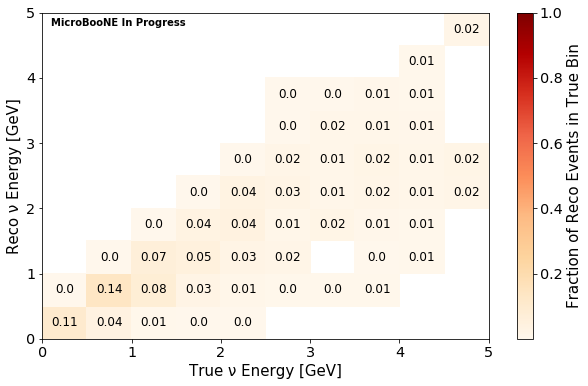

In [55]:
current_genie_weights = _get_genie_weight(
                nue_nue, 'nu_e', query=TOTAL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


current_genie_weights2 = _get_genie_weight(
                nue_nue, 'reco_e', query=TOTAL_QUERY, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")


current_genie_weights3 = _get_genie_weight(
                nue_nue, 'nu_e', query=truthsel_nue_only, track_cuts=None,select_longest=False, weightvar="weightSplineTimesTuneTimesPPFX")

test_list1 = current_genie_weights
test_list2 = current_genie_weights2

if len(test_list1) == len(test_list2) and len(test_list1) == sum([1 for i, j in zip(test_list1, test_list2) if i == j]):
    print("All is well.")
else:
    print("Oh no.")

bins = np.arange(0, 5.5, 0.5)

var1 = nue_nue.query(TOTAL_QUERY)['nu_e']
weight1 = current_genie_weights * weights["nue_nue"]


var2 = nue_nue.query(TOTAL_QUERY)['reco_e']
weight2 = current_genie_weights2* weights["nue_nue"]


var3 = nue_nue.query(truthsel_nue_only)['nu_e']
weight3 = current_genie_weights3* weights["nue_nue"]



# relationship between true & reco values
plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins)

plot_smearing(var1, var2, weight1, weight2, var3, weight3, bins, norm=True)

### Now look at Efficiency

In [34]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(selected, df, signal, bins, variable, xaxis, savetitle): 
    
    # generated true signal events per bin 
    gen = plt.hist(df.query(signal)[variable], bins, color='deepskyblue')
    plt.close()
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    # compute efficiency
    #sel2=selected['nu_e']
    sel = ax1.hist(selected[variable], bins, color='white')
    print("sel = ", sel)
    print("")
    print("gen = ", gen)
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    ax1.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax1.set_ylim(0, 0.30)
    ax1.set_ylabel('Efficiency', fontsize=15)
    ax1.set_title("Efficiency")
    ax1.set_xlabel(xaxis)
    
    np.savetxt(savetitle,
           eff,
           delimiter =", ", 
           fmt ='% s')

    plt.show()

sel =  (array([ 394., 2785., 1837.,  601.,  231.,   75.,   39.,   20.,    9.,
          3.]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]), <a list of 10 Patch objects>)

gen =  (array([ 3073., 16077., 12086.,  4874.,  2003.,   948.,   552.,   276.,
         139.,    59.]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]), <a list of 10 Patch objects>)
In bin 0 , eff =  0.1282134721770257  with error =  0.0060310180371728654
In bin 1 , eff =  0.17322883622566398  with error =  0.0029846969955259197
In bin 2 , eff =  0.15199404269402614  with error =  0.0032656635575210625
In bin 3 , eff =  0.12330734509643004  with error =  0.004709506440308249
In bin 4 , eff =  0.11532700948577135  with error =  0.0071370119640335435
In bin 5 , eff =  0.07911392405063292  with error =  0.008766480024320945
In bin 6 , eff =  0.07065217391304347  with error =  0.010906423801356284
In bin 7 , eff =  0.07246376811594203  with error =  0.015605272523425088
In bin 8 , eff =  

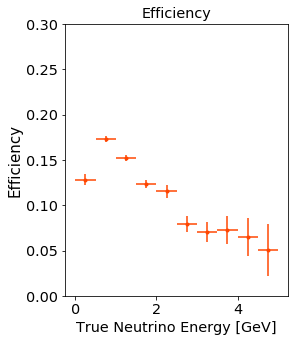

In [35]:
#ENERGY

#this is the truth selection
fiduc_q = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
fiduc_q  += " and category == 11"


variable = 'nu_e'
xaxis = "True Neutrino Energy [GeV]"
savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_trueeff.csv"


bins = np.arange(0, 5.5, 0.5)
#plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

selected = nue_nue.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

#had truth as mc - should be nue?
plot_signal_and_eff(selected_fid, nue_nue, fiduc_q, bins, variable, xaxis, savetitle)

sel =  (array([  63.,   92.,  135.,  164.,  224.,  352.,  489.,  777., 1290.]), array([-1.00000000e+00, -8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
       -2.00000000e-01, -2.22044605e-16,  2.00000000e-01,  4.00000000e-01,
        6.00000000e-01,  8.00000000e-01]), <a list of 9 Patch objects>)

gen =  (array([ 727.,  766.,  869., 1103., 1305., 1873., 2500., 3584., 5975.]), array([-1.00000000e+00, -8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
       -2.00000000e-01, -2.22044605e-16,  2.00000000e-01,  4.00000000e-01,
        6.00000000e-01,  8.00000000e-01]), <a list of 9 Patch objects>)
In bin 0 , eff =  0.08665749656121045  with error =  0.010434044824723475
In bin 1 , eff =  0.12010443864229765  with error =  0.011745748770447999
In bin 2 , eff =  0.15535097813578827  with error =  0.012288114502639039
In bin 3 , eff =  0.1486854034451496  with error =  0.010712515208485084
In bin 4 , eff =  0.17164750957854405  with error =  0.010438091237629545
In bin 5 , eff =  0.187933

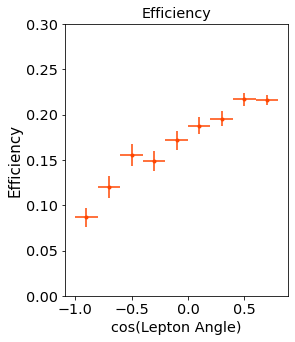

In [38]:
# ANGLE

#this is the truth selection
fiduc_q = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
fiduc_q  += " and category == 11"

variable = 'cosNu_Angle_Numi_Elec_asmuon'
xaxis = "cos(Lepton Angle)"
savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_AngleDiff_matrix_trueeff.csv"


bin_width = 0.2
bins = np.arange(-1, 1, bin_width)
#plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

selected = nue_nue.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

#had truth as mc - should be nue?
plot_signal_and_eff(selected_fid, nue_nue, fiduc_q, bins, variable, xaxis, savetitle)

sel =  (array([3.326e+03, 2.076e+03, 4.290e+02, 1.170e+02, 3.700e+01, 7.000e+00,
       1.000e+00, 1.000e+00, 0.000e+00]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]), <a list of 9 Patch objects>)

gen =  (array([2.694e+04, 9.326e+03, 2.511e+03, 8.300e+02, 3.070e+02, 1.180e+02,
       4.600e+01, 5.000e+00, 1.000e+00]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]), <a list of 9 Patch objects>)
In bin 0 , eff =  0.12345953971789161  with error =  0.0020042390281735656
In bin 1 , eff =  0.2226034741582672  with error =  0.004307641588030057
In bin 2 , eff =  0.17084826762246116  with error =  0.007511020366805268
In bin 3 , eff =  0.14096385542168674  with error =  0.012078710080652588
In bin 4 , eff =  0.12052117263843648  with error =  0.018581260882267775
In bin 5 , eff =  0.059322033898305086  with error =  0.02174640632545545
In bin 6 , eff =  0.021739130434782608  with error =  0.021501537175949575
In bin 7 , eff =  0.2  with error =  0.1788854381999832
In

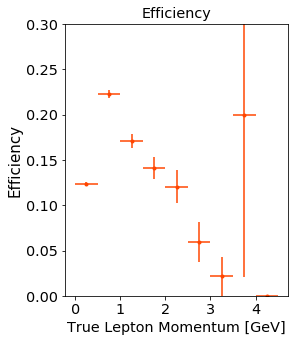

In [39]:
# LEPTON MOMENTUM

#this is the truth selection
fiduc_q = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
fiduc_q  += " and category == 11"

variable = 'targetP_asmuon'
xaxis = "True Lepton Momentum [GeV]"
savetitle = "batch_eff_nue_fig_full_500_catsel_nopions_LeptonMom_matrix_trueeff.csv"


bin_width = 0.5
bins = np.arange(0, 5.0, bin_width)
#plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

selected = nue_nue.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

#had truth as mc - should be nue?
plot_signal_and_eff(selected_fid, nue_nue, fiduc_q, bins, variable, xaxis, savetitle)

### Smearing Matrix work

In [52]:
# plot the smearing matrix 
def plot_smearing(selected, signal, df, true, reco, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(selected.query(signal)[true],selected.query(signal)[reco],
                   bins, cmin=0.000000001, cmap='OrRd')
    
    zero_copy_smear = np.copy(smear[0].T)
    
    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if np.isnan(zero_copy_smear[i,j]):
                zero_copy_smear[i,j]= 0

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
        
        gen = plt.hist(df.query(signal)['nu_e'], bins, color='deepskyblue')
        print(gen[0])
        plt.close()
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            #reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            #tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1):
                norm_array[i][j] =  norm_array[i][j] / gen[0][j]
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
        
        zero_copy_smear_norm = np.copy(norm_array)

        for i in range(len(bins)-1): # reco bins i (y axis) rows
            for j in range(len(bins)-1): # true bins j (x axis) cols
                if np.isnan(zero_copy_smear_norm[i,j]):
                    zero_copy_smear_norm[i,j]= 0

        print(zero_copy_smear_norm)
    
        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)
        
        np.savetxt("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv", 
           zero_copy_smear_norm,
           delimiter =", ", 
           fmt ='% s')

    plt.xlabel('True ν Energy [GeV]', fontsize=15)
    plt.ylabel('Reco ν Energy [GeV]', fontsize=15)
    plt.text(0.1, 4.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()

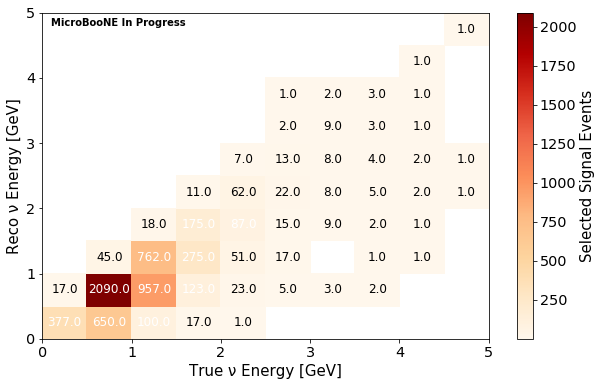

In [53]:
# true nu energy 
true_var = 'nu_e'

# reconstructed nu energy 
reco_var = 'reco_e'

bins = np.arange(0, 5.5, 0.5)

#fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 12 and ccnc == 0) and nproton > 0"

fiduc_q  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
fiduc_q  += " and category == 11"

#keep category as it gets the bit we will select from truth, not stuff out of fid vol, dirt, etc


selected = nue.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, nue, true_var, reco_var, bins)

[ 3073. 16077. 12086.  4874.  2003.   948.   552.   276.   139.    59.]
[[0.123 0.04  0.008 0.003 0.    0.    0.    0.    0.    0.   ]
 [0.006 0.13  0.079 0.025 0.011 0.005 0.005 0.007 0.    0.   ]
 [0.    0.003 0.063 0.056 0.025 0.018 0.    0.004 0.007 0.   ]
 [0.    0.    0.001 0.036 0.043 0.016 0.016 0.007 0.007 0.   ]
 [0.    0.    0.    0.002 0.031 0.023 0.014 0.018 0.014 0.017]
 [0.    0.    0.    0.    0.003 0.014 0.014 0.014 0.014 0.017]
 [0.    0.    0.    0.    0.    0.002 0.016 0.011 0.007 0.   ]
 [0.    0.    0.    0.    0.    0.001 0.004 0.011 0.007 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.007 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.017]]


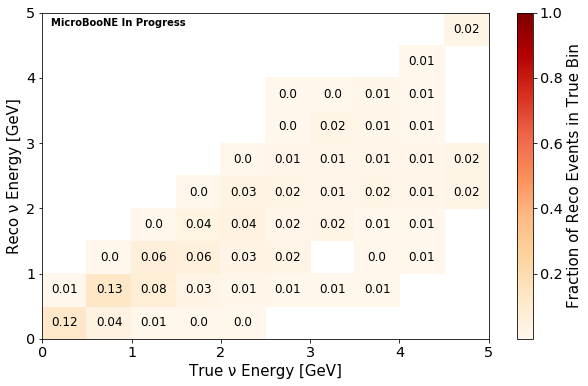

In [54]:
# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, nue, true_var, reco_var, bins, norm=True)

In [55]:
with open('batch_eff_nue_fig_full_500_catsel_nopions_recoE_matrix_trueeff.csv') as file:
    content = file.readlines()
effs = content[0:]
    
for i in range(10):
    effs[i]=effs[i].rstrip().rstrip(',')
    effs[i] = float(effs[i])
    
print(effs)
print("")
#----------------------------------------------------------------------------------

with open('nue_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv') as file:
    content = file.readlines()
smear = content[0:]

for i in range(10):
    smear[i]=smear[i].rstrip().rstrip(',')
    smear[i] = [float(idx) for idx in smear[i].split(', ')]
    
print("Smearcept: ")
print((smear))
print("")
print("")

#------------------------------------------------------------------
#Should be efficiency noramlised by dividing by truth
"""
#print(np.dot(effs, data_signal))
for i in range(10):
    smear[i] = [a*b for a,b in zip(smear[i], effs)]
    
print(smear)
print("")

np.savetxt("nue_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv", 
   smear,
   delimiter =", ", 
   fmt ='% s')
"""
#--------------------------------------------------------

#Now test by multiplying with the prior_true_signal

with open('nue_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal.csv') as file:
    content = file.readlines()
prior_true = content[0:]
    
for i in range(10):
    prior_true[i]=prior_true[i].rstrip().rstrip(',')
    prior_true[i] = float(prior_true[i])
    
print("Prior Truth: ")
print(prior_true)
print("")

made_data_sig = np.dot(smear, prior_true)
print("Recreated Truth: ")
print(made_data_sig)
print("")

for i in made_data_sig:
    print(i)

[0.1282134721770257, 0.17322883622566398, 0.15199404269402614, 0.12330734509643004, 0.11532700948577135, 0.07911392405063292, 0.07065217391304347, 0.07246376811594203, 0.06474820143884892, 0.05084745762711865]

Smearcept: 
[[0.12268141880898145, 0.04043042856254276, 0.008274036074797287, 0.003487894952810833, 0.0004992511233150275, 0.0, 0.0, 0.0, 0.0, 0.0], [0.005532053368044257, 0.12999937799340672, 0.07918252523581003, 0.025235945835043086, 0.011482775836245632, 0.005274261603375527, 0.005434782608695652, 0.007246376811594203, 0.0, 0.0], [0.0, 0.002799029669714499, 0.06304815488995533, 0.05642183011899877, 0.0254618072890664, 0.017932489451476793, 0.0, 0.0036231884057971015, 0.007194244604316547, 0.0], [0.0, 0.0, 0.0014893264934635116, 0.0359048009848174, 0.04343484772840739, 0.015822784810126583, 0.016304347826086956, 0.007246376811594203, 0.007194244604316547, 0.0], [0.0, 0.0, 0.0, 0.0022568732047599507, 0.0309535696455317, 0.023206751054852322, 0.014492753623188406, 0.018115942028

In [ ]:
##------------------------------------------------------------------